This script identifies the tissue in virtual or real histology

In [ ]:
image_directory = '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/'

In [ ]:
#@title Install
if not ('run_it' in locals() or 'run_it' in globals()):
  from google.colab import drive
  from IPython.display import clear_output

  drive.mount('/content/drive/')
  !git clone --recurse-submodules https://github.com/WinetraubLab/zero_shot_segmentation.git
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference

  !pip install torch
  !pip install torchvision
  %pip install dataclasses-json
  %pip install supervision
  import torch
  import torchvision
  import sys
  import numpy as np

  sys.path.append('/content/zero_shot_segmentation')
  from zero_shot_utils.utils import visualize_masks_on_img
  import cv2
  import matplotlib.pyplot as plt

  sys.path.append('/content/OCT2Hist-ModelInference')
  from utils.show_images import showImg

  # rf - roboflow
  rf_api_key="R04BinsZcBZ6PsfKR2fP"
  rf_workspace="yolab-kmmfx"
  rf_project = "connect_from_colab"
  rf_dataset = "png-mask-semantic"
  using_colab = True
  visualize_sam_outputs = True
  sam_checkpoint = "sam_vit_h_4b8939.pth"
  model_type = "vit_h"
  %run /content/zero_shot_segmentation/setup_roboflow_and_sam.ipynb

  from segment_skin_in_he_images import SegmentSkinInHEImages
  clear_output()
  run_it = False

In [ ]:
import random

# List all files in the directory
all_images = os.listdir(image_directory)

# Filter out images without the suffix _realB
filtered_images = [img for img in all_images if "fake_B" in img]
random.shuffle(filtered_images)
filtered_images = filtered_images[:10]

# Uncomment this part if you would like to try a single image rather than all.
#filtered_images = ['']

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/' already exists.
Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/segment_skin/' already exists.
LG-27-Slide08_Section03_yp0_patch01_fake_B.png


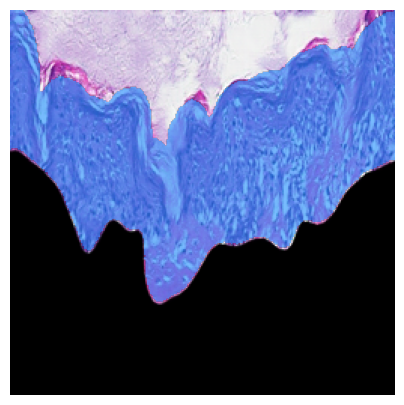

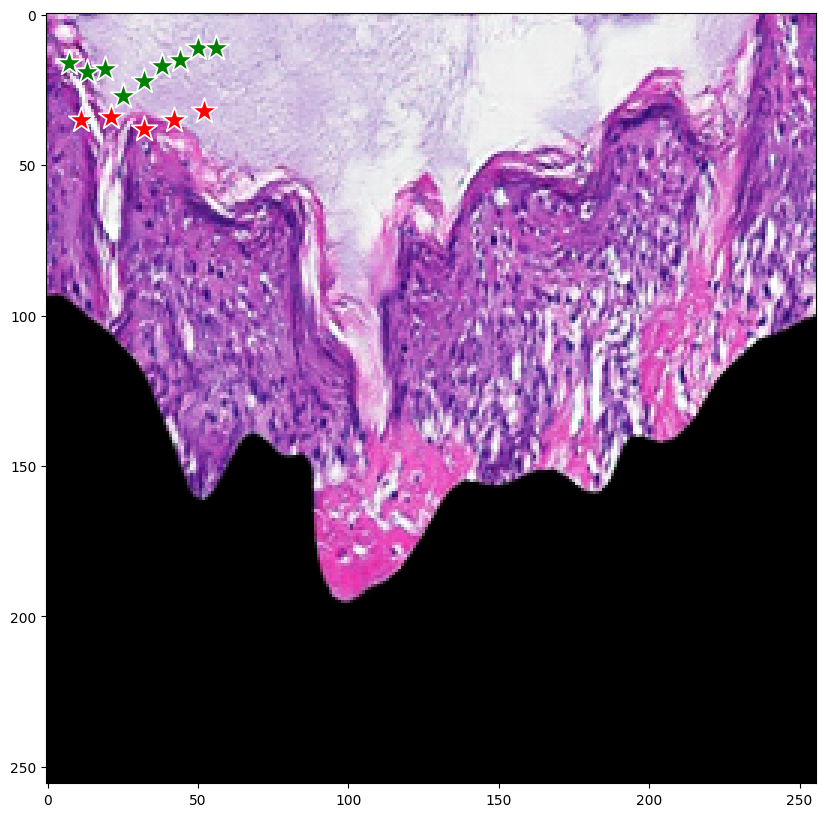

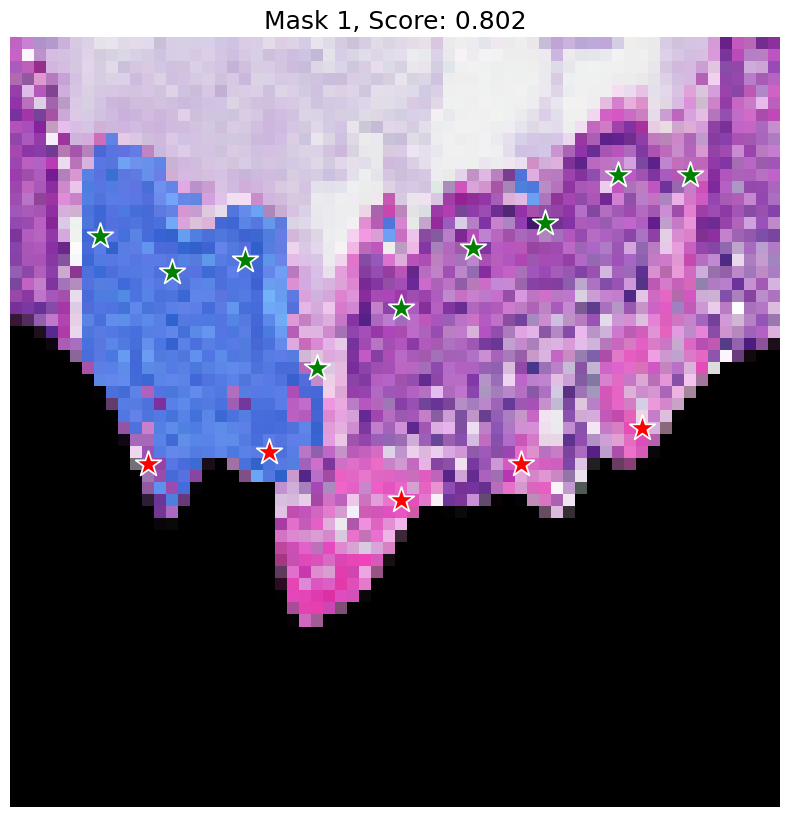

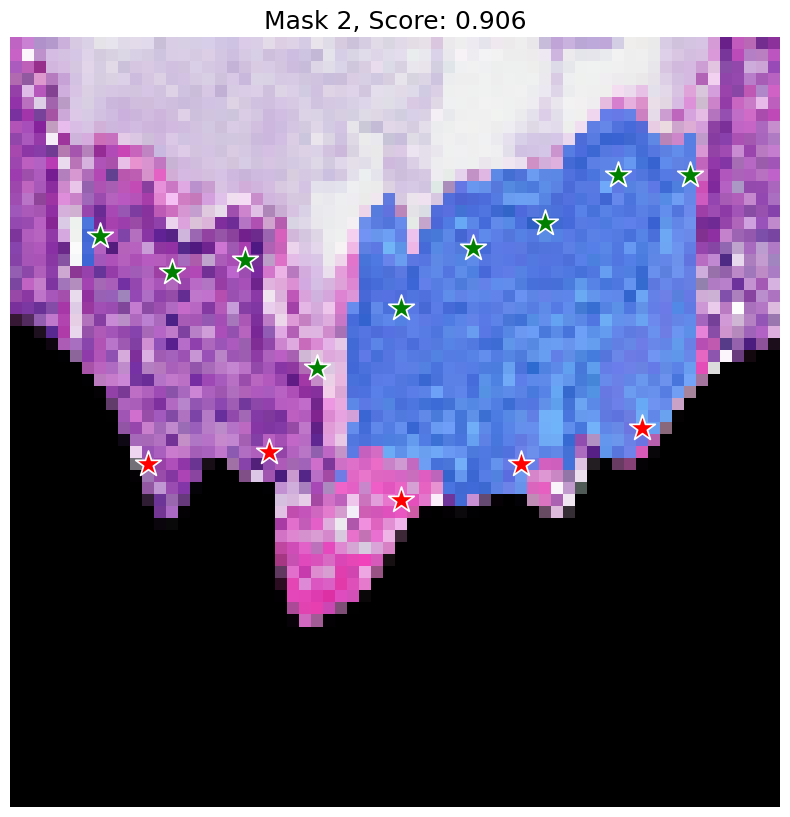

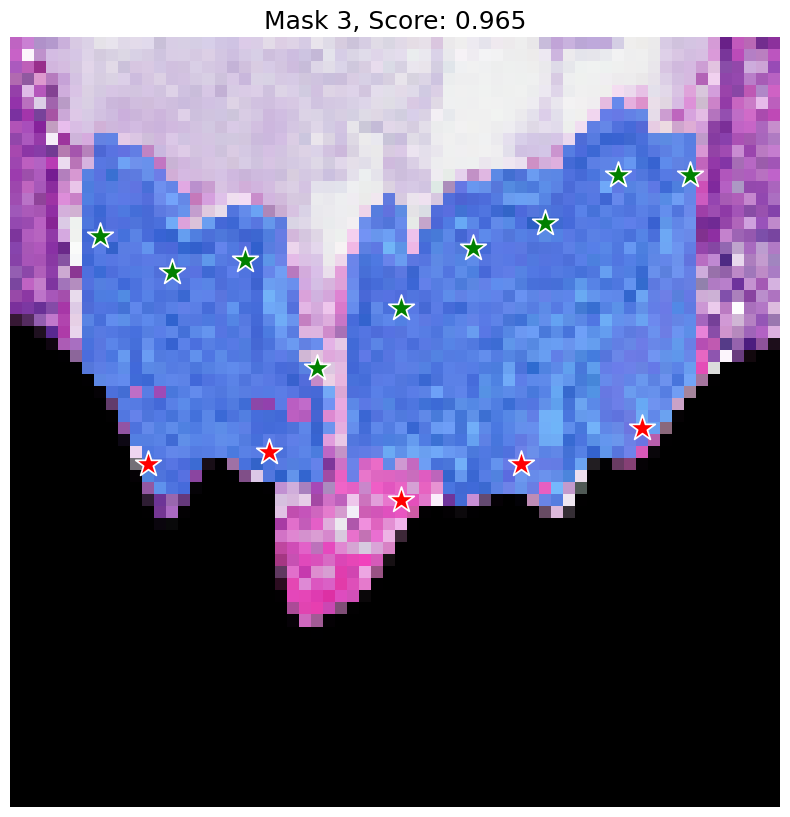

In [ ]:

s = SegmentSkinInHEImages(sam)
for image_path in filtered_images:
  print(image_path)
  im_he = cv2.imread(image_directory+image_path)
  im_he = cv2.cvtColor(im_he, cv2.COLOR_BGR2RGB)

  im_oct = cv2.imread(image_directory+image_path.replace("fake_B", "real_A"))
  im_oct = cv2.cvtColor(im_oct, cv2.COLOR_BGR2RGB)

  mask = s.segment_skin_from_gel(im_he, im_oct, True)

  # Pick points close to the top and bottom of the mask, these will help find
  # dermal / epidermal junction
  break

scale = 1
scaled_he = cv2.resize(im_he, (
      int(im_he.shape[0]/scale), int(im_he.shape[1]/scale)))
scaled_mask = cv2.resize(mask.astype(np.float32), (
      int(im_he.shape[0]/scale), int(im_he.shape[1]/scale))) > 0.5

def _get_mask_outline(mask):
  # Dimensions of sam_mask
  num_rows = len(mask)
  num_cols = len(mask[0])
  xs = []
  top_ys = []
  bottom_ys = []

  # Iterate over all x positions
  for x in range(num_cols):
      top_y = None
      bottom_y = None

      # Iterate over y positions
      for y in range(num_rows):
          if mask[y][x]:
              if top_y is None:
                  top_y = y
              bottom_y = y

      # Check if any True value was found in the column
      if top_y is not None:
        xs.append(x)
        top_ys.append(top_y)
        bottom_ys.append(bottom_y)

  xs = np.array(xs)
  top_ys = np.array(top_ys)
  bottom_ys = np.array(bottom_ys)

  return xs, top_ys, bottom_ys

def _mask_outline_to_points_of_interest(xs, ys, offset, n_points):
  indexes = np.linspace(0, len(xs)-1, n_points+2, dtype=int)
  indexes = indexes[1:-1]
  xs = np.array(xs[indexes], dtype=int)
  ys = np.array(ys[indexes], dtype=int)
  offset = int(offset)

  points_x = xs
  points_y = ys + offset

  return points_x, points_y

def _add_points_to_point_label(xy_tuple, label, input_point, input_label):
  x = xy_tuple[0]
  y = xy_tuple[1]
  for i in range(len(x)):
    pt = [x[i], y[i]]
    input_point.append(pt)
    input_label.append(label)

  return input_point, input_label

# Capture outline
xs_um, top_yps_um, bottom_ys_um = _get_mask_outline(scaled_mask)

# Remove from outline areas that top and bottom are too close
threshold_um = 50/scale
indices_to_keep = np.where(bottom_ys_um - top_yps_um > threshold_um)
xs_um = xs_um[indices_to_keep]
top_yps_um = top_yps_um[indices_to_keep]
bottom_ys_um = bottom_ys_um[indices_to_keep]

input_point, input_label = _add_points_to_point_label(
    _mask_outline_to_points_of_interest(
        xs_um, top_yps_um, offset=20/scale, n_points=9), 1,
    [],[]) # Epidermis
input_point, input_label = _add_points_to_point_label(
    _mask_outline_to_points_of_interest(
        xs_um, bottom_ys_um, offset=-10/scale, n_points=5), 0,
    input_point,input_label) # Dermis

input_point = np.array(input_point)
input_label = np.array(input_label)


from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

predictor = SamPredictor(sam)
predictor.set_image(scaled_he)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


#input_point = np.array([[60, 100],[130, 80], [190, 60], [230, 40], [60, 180], [130, 160],[190, 130],[230, 110]])
#input_label = np.array([1,1,1,1,0,0,0,0])

plt.figure(figsize=(10,10))
plt.imshow(im_he)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(scaled_he)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

LD-11-Slide07_Section01_yp0_patch01_fake_B.png


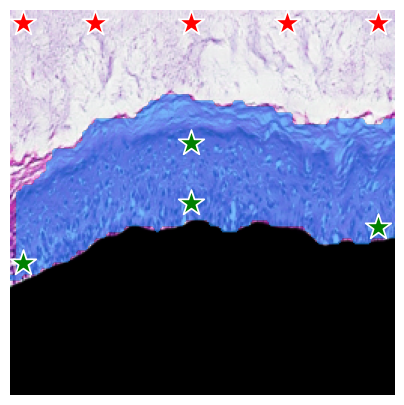

LGC-58-Slide07_Section03_yp0_patch01_fake_B.png


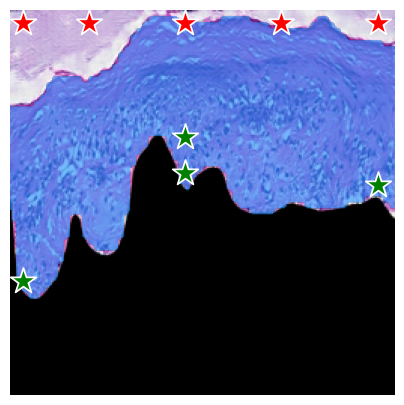

LGC-50-Slide05_Section03_yp0_patch01_fake_B.png


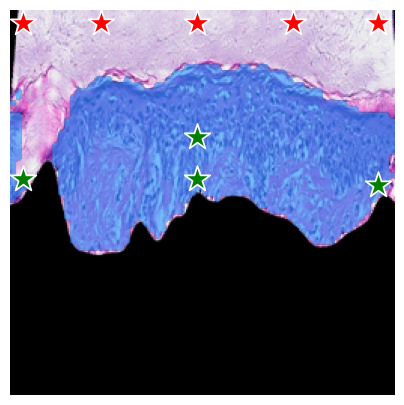

LG-37-Slide03_Section02_yp0_patch01_fake_B.png


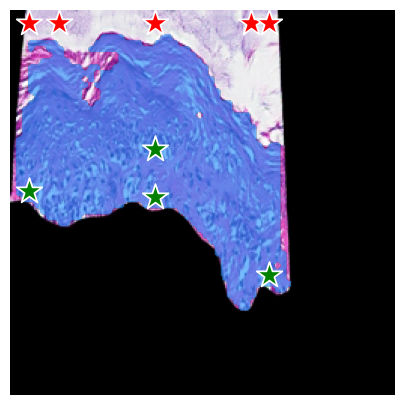

LG-70-Slide04_Section03_yp0_patch01_fake_B.png


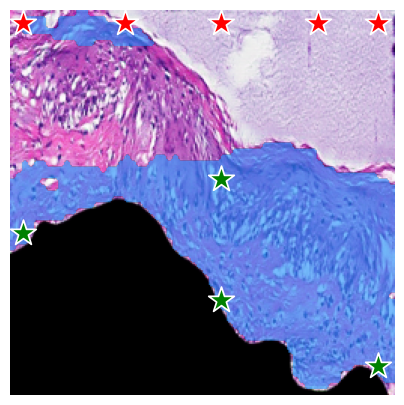

LG-72-Slide05_Section02_yp0_patch01_fake_B.png


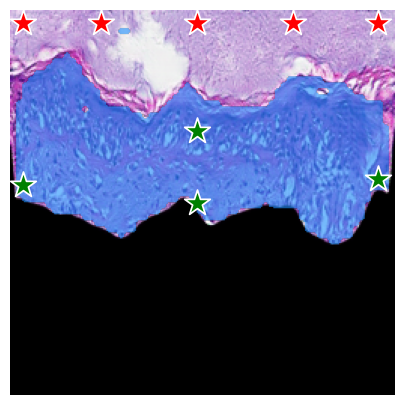

LG-70-Slide05_Section01_yp0_patch01_fake_B.png


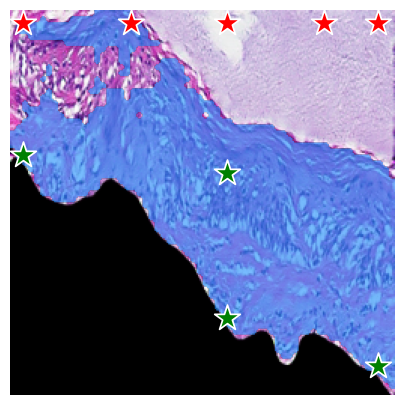

LGC-12-Slide05_Section01_yp0_patch01_fake_B.png


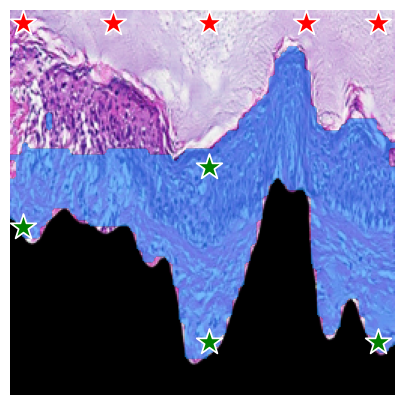

LG-78-Slide05_Section03_yp0_patch01_fake_B.png


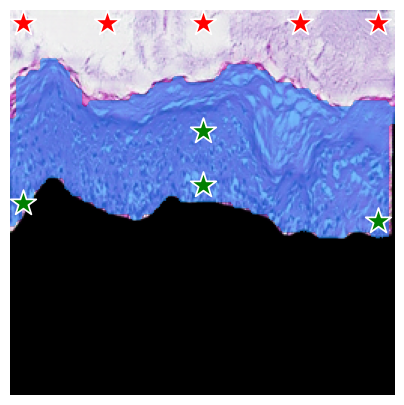

LG-72-Slide05_Section03_yp0_patch01_fake_B.png


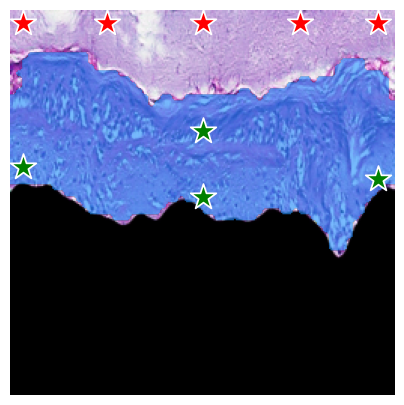

In [ ]:
for image_path in filtered_images:
  print(image_path)
  input = cv2.imread(image_directory+image_path)
  oct_image = cv2.imread(
      (image_directory+image_path).replace("fake_B", "real_A"))
  input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

  he_image = input
  scaled_image = cv2.resize(he_image, (64, 64))
  points_array, points_label = s._compute_points_of_interest(scaled_image)
  points_array[0][1] = points_array[0][1]+4

  # Do the SAM thing
  s.predictor.set_image(scaled_image)
  masks, scores, logits = s.predictor.predict(
    point_coords=points_array,
    point_labels=points_label,
    multimask_output=False,
    )
  mask = masks[0]

  mask = cv2.resize(mask.astype(np.float32), (256, 256))
  mask = mask>0.5

  im_gray = cv2.cvtColor(he_image, cv2.COLOR_RGB2GRAY)
  mask = mask*np.array(im_gray > 0)

  s._visualize_results(he_image, mask, points_array*4, points_label)

  #plt.title(image_path)
  #plt.show()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/' already exists.
Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/segment_skin/' already exists.
LD-11-Slide07_Section01_yp0_patch01_fake_B.png


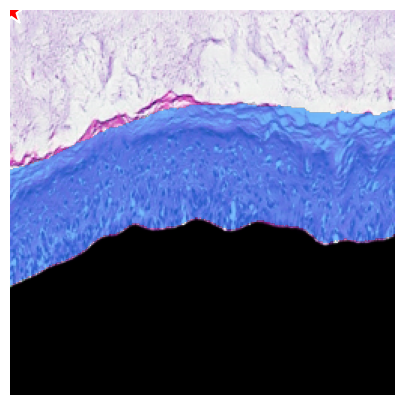

LGC-58-Slide07_Section03_yp0_patch01_fake_B.png


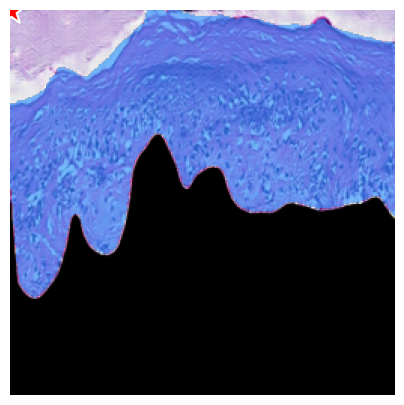

LGC-50-Slide05_Section03_yp0_patch01_fake_B.png


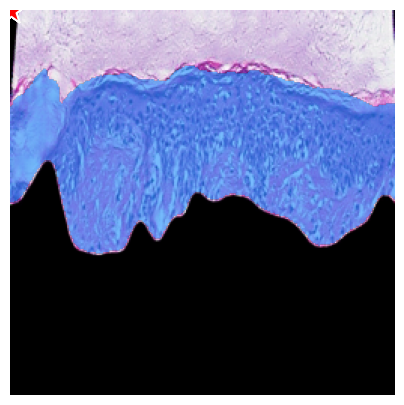

LG-37-Slide03_Section02_yp0_patch01_fake_B.png


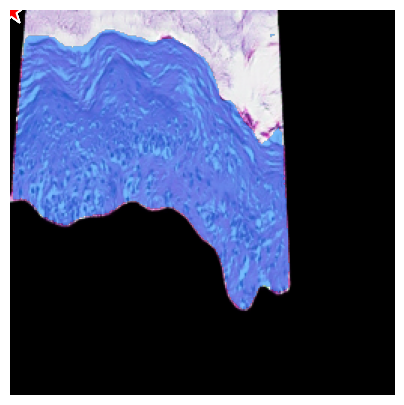

LG-70-Slide04_Section03_yp0_patch01_fake_B.png


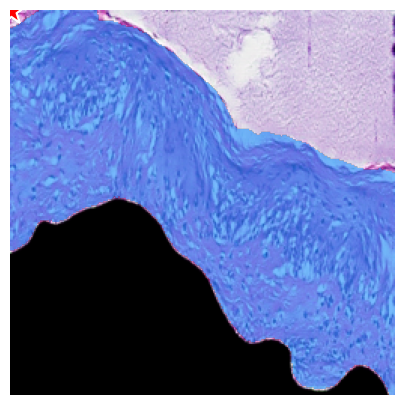

LG-72-Slide05_Section02_yp0_patch01_fake_B.png


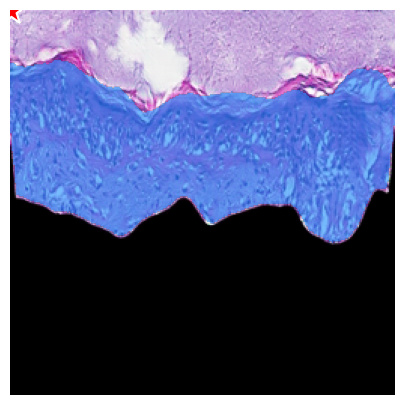

LG-70-Slide05_Section01_yp0_patch01_fake_B.png


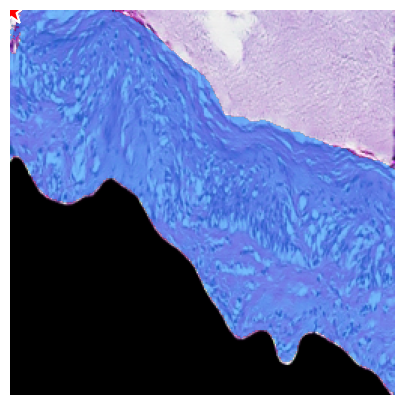

LGC-12-Slide05_Section01_yp0_patch01_fake_B.png


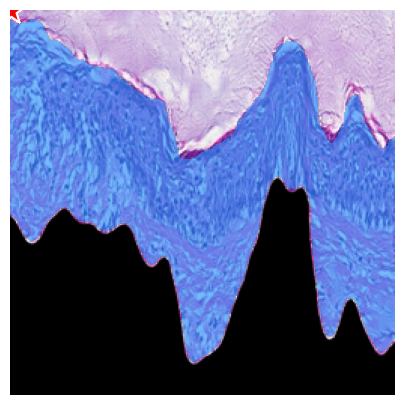

LG-78-Slide05_Section03_yp0_patch01_fake_B.png


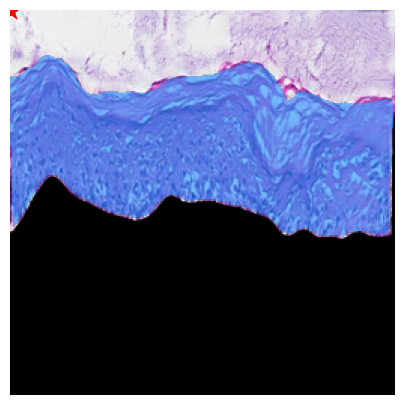

LG-72-Slide05_Section03_yp0_patch01_fake_B.png


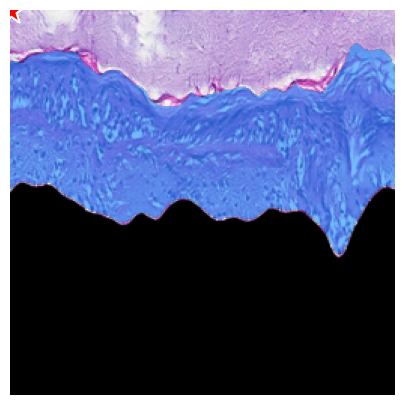

In [ ]:
a=31.2

import segment_skin_in_oct_images

segment_skin_in_oct_images.setup_network()

for image_path in filtered_images:
  print(image_path)
  input = cv2.imread(image_directory+image_path)
  oct_image = cv2.imread(
      (image_directory+image_path).replace("fake_B", "real_A"))
  input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

  mask = segment_skin_in_oct_images.run_network(oct_image)

  s._visualize_results(input, mask, points_array*0, points_label)

  #plt.title(image_path)
  #plt.show()